In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/data.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [16]:
!python train.py5
8905


流式输出内容被截断，只能显示最后 5000 行内容。
iteration_50002 loss_cls_0.0002831478777807206
iteration_50003 loss_cls_2.726899538174621e-06
iteration_50004 loss_cls_0.00019354333926457912
iteration_50005 loss_cls_0.002147227991372347
iteration_50006 loss_cls_7.126222044462338e-05
iteration_50007 loss_cls_2.702875281102024e-05
iteration_50008 loss_cls_0.025497548282146454
iteration_50009 loss_cls_1.5139197785174474e-05
iteration_50010 loss_cls_0.00030278146732598543
iteration_50011 loss_cls_0.012843978591263294
iteration_50012 loss_cls_8.61186272231862e-05
iteration_50013 loss_cls_0.0004909808048978448
iteration_50014 loss_cls_3.452363671385683e-05
iteration_50015 loss_cls_0.010142851620912552
iteration_50016 loss_cls_0.00013738394773099571
iteration_50017 loss_cls_6.794825821998529e-06
iteration_50018 loss_cls_0.0001798331504687667
iteration_50019 loss_cls_0.009008974768221378
iteration_50020 loss_cls_0.00045085782767273486
iteration_50021 loss_cls_0.0015091088134795427
iteration_50022 loss_cls_6.7658736

In [5]:
import torch
from ResNet import ResNet50
num_classes=4
model = ResNet50(num_classes, channels=1)
model.load_state_dict(torch.load('/content/iter_55000.pth'))
model.cuda()
model.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [26]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import transforms
import joint_transforms
import random
from dataloader import SBU
from torchvision.transforms import Grayscale

joint_transform = joint_transforms.Compose([
  joint_transforms.RandomHorizontallyFlip(),
  joint_transforms.Resize((288, 288))
  ])

img_transform = transforms.Compose([
  transforms.ToTensor(),

  transforms.Normalize((0.5,), (0.5,)),

  ])

def worker_init_fn(worker_id):
  random.seed(1337 + worker_id)

test_data_path = '/content/data/train/'


test_dataset = SBU(root=test_data_path, transform=img_transform,joint_transform=joint_transform,mod='union', multi_task=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, worker_init_fn=worker_init_fn, num_workers=0)




In [8]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 测试模型
predictions = []
labels = []

with torch.no_grad():
    for  sampled_batch in test_dataloader:
        images = sampled_batch['image'].to(device)
        targets = sampled_batch['cls'].to(device)

        # 获取模型预测概率
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        predictions.extend(probabilities.cpu().numpy())
        labels.extend(targets.cpu().numpy())

predictions = np.array(predictions)
labels = np.array(labels)

# 计算准确率
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print('准确率：', accuracy)


准确率： 0.6421841541755888


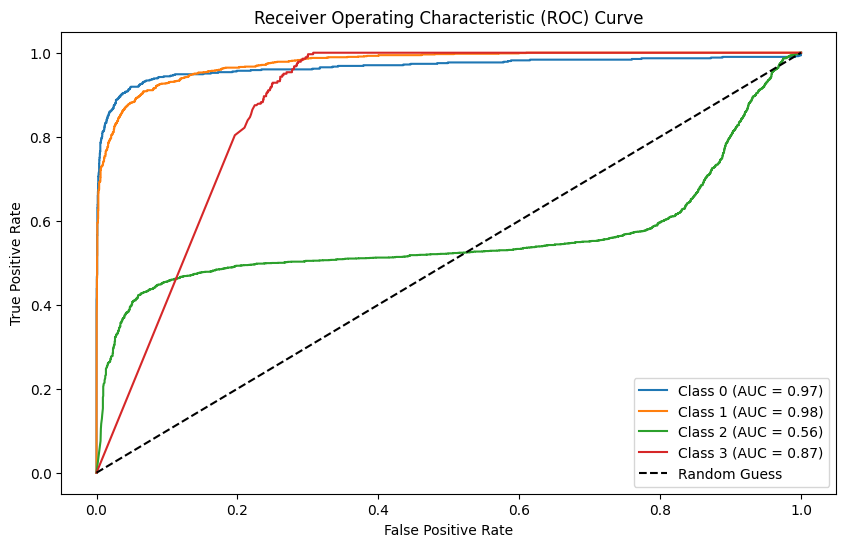

平均AUC： 0.8435017328540622


In [196]:
# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(labels[:, i], predictions[:, i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



# 计算平均 AUC
mean_auc = np.mean(list(roc_auc.values()))
print('平均AUC:', mean_auc)


In [194]:

print(true_labels)

[1 1 3 ... 2 1 2]


In [171]:
import torch.utils.data as data
from PIL import Image
import torch
import os


def make_union_dataset(root):
    img_list = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(root, 'image')) if f.endswith('.png')]
    label_list = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(root, 'mask')) if f.endswith('.png')]
    data_list = []
    for img_name in img_list:
        data_list.append((os.path.join(root, 'image', img_name + '.png'),
                          os.path.join(root, 'mask', img_name + '.png')
                          ))

    return data_list


root = './data/test/'
joint_transform = None  # Define your joint transformation here
transform = None  # Define your transformation here
mod = 'union'
multi_task = True

assert (mod in ['union', 'labeled'])
imgs = make_union_dataset(root)

for index in range(len(imgs)):
    img_path, gt_path = imgs[index]
    img = Image.open(img_path).convert('L')
    n = -1
    i_name = img_path.split("/")[-1]

    for d in os.listdir('./data/test/img'):
        if i_name in os.listdir(os.path.join('./data/test/img', d)):
            n = d
            #print(n)
    l = torch.zeros(4)
    l[int(n) - 1] = 1
    number_per = l
    #print (number_per)

    if gt_path != -1:
        target = Image.open(gt_path).convert('L')
        if joint_transform is not None:
            img, target = joint_transform(img, target)
        if transform is not None:
            img = transform(img)
            target = transform(target)
        if multi_task:
            sample = {'image': img, 'label': target, 'cls': number_per}
    #print (sample['cls'])




tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 0., 1.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([1., 0., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 1.])
tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 1.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])


ResNet50

准确率： 0.6421841541755888


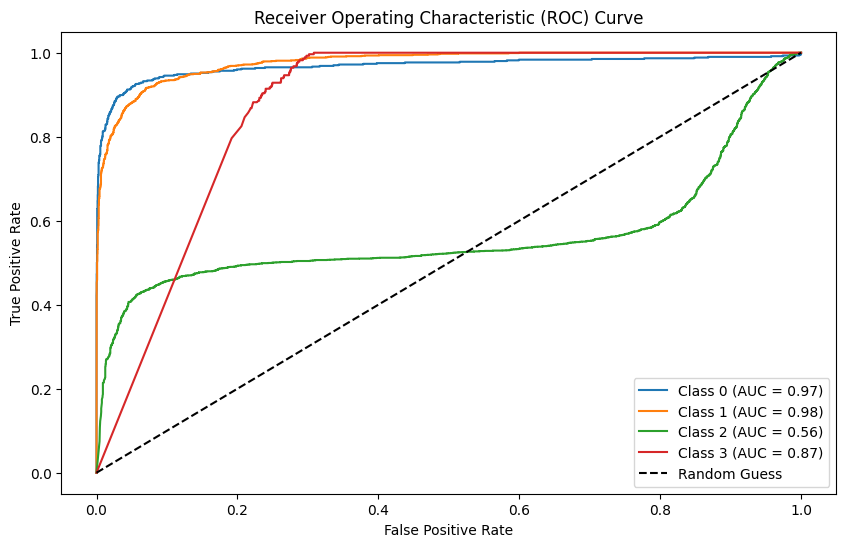

精确率： 0.7010844355920757
平均AUC： 0.8450486135751235


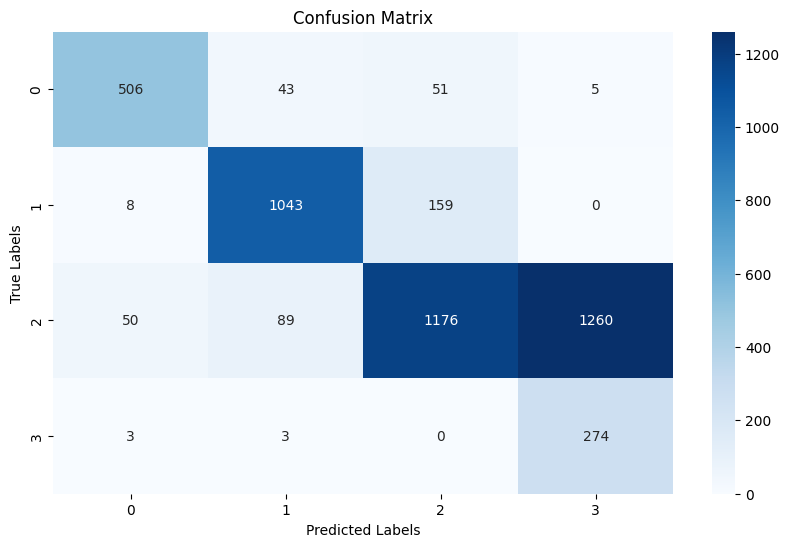

召回率： 0.7834043912839146
F1 分数： 0.658017361285691


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, f1_score, precision_score
import seaborn as sns
import numpy as np
# 计算准确率
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print('准确率：', accuracy)

# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(labels[:, i], predictions[:, i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


# 计算精确率
precision = precision_score(true_labels, predicted_labels, average='macro')

print('精确率：', precision)

# 计算平均 AUC
mean_auc = np.mean(list(roc_auc.values()))
print('平均AUC：', mean_auc)

# 计算混淆矩阵
confusion_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 计算召回率和 F1 分数
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print('召回率：', recall)
print('F1 分数：', f1)


Conformer

In [24]:
from timm.layers.weight_init import trunc_normal_
import torch
from conformer import Conformer
from timm.models.layers import DropPath, trunc_normal_
num_classes=4
model = Conformer(num_classes=4)
model.load_state_dict(torch.load('./iter_55000(2).pth'))
model.eval()

Conformer(
  (trans_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (trans_cls_head): Linear(in_features=768, out_features=4, bias=True)
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (conv_cls_head): Linear(in_features=1024, out_features=4, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_1): ConvBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 测试模型
predictions = []
labels = []

with torch.no_grad():
    for  sampled_batch in test_dataloader:
        images = sampled_batch['image'].to(device)
        targets = sampled_batch['cls'].to(device)
        #print(images.shape)
        # 获取模型预测概率
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        predictions.extend(probabilities.cpu().numpy())
        labels.extend(targets.cpu().numpy())

predictions = np.array(predictions)
labels = np.array(labels)

准确率： 0.6032119914346895


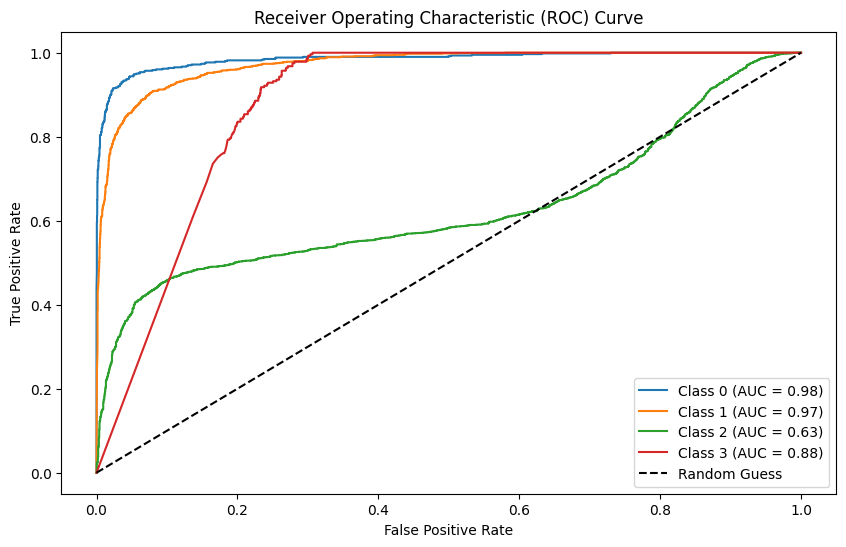

精确率： 0.6804540032692197
平均AUC： 0.8662395402392435


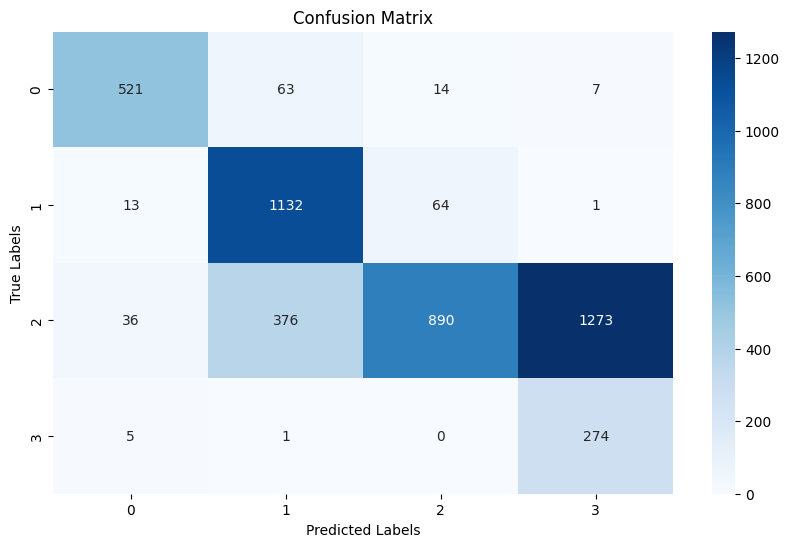

召回率： 0.7802241778521567
F1 分数： 0.624472641464643


In [29]:
# 计算准确率
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print('准确率：', accuracy)

# 计算每个类别的 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(labels[:, i], predictions[:, i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


# 计算精确率
precision = precision_score(true_labels, predicted_labels, average='macro')

print('精确率：', precision)

# 计算平均 AUC
mean_auc = np.mean(list(roc_auc.values()))
print('平均AUC：', mean_auc)

# 计算混淆矩阵
confusion_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 计算召回率和 F1 分数
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print('召回率：', recall)
print('F1 分数：', f1)

In [14]:
!pip show timm

Name: timm
Version: 0.9.2
Summary: PyTorch Image Models
Home-page: https://github.com/huggingface/pytorch-image-models
Author: Ross Wightman
Author-email: ross@huggingface.co
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, pyyaml, safetensors, torch, torchvision
Required-by: 
